<a href="https://colab.research.google.com/github/Beanzema/sdudying/blob/main/hw_5(2)_Naver_Shopping_Review_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 네이버 쇼핑 리뷰 감성 분류하기(Naver Shopping Review Sentiment Analysis)

# 0. Colab에 Mecab 설치
* 네이버 영화 리뷰 감성 분석에는 Okt(Open Korean Text)를 사용했다면, 쇼핑 리뷰 감성 분류에서는 Mecab을 사용한다.
* Cf) Okt(Open Korean Text)는 트위터에서 만든 오픈소스 한국어 처리기인 twitter-korean-text를 이어받아 만들고 있는 프로젝트다.

In [4]:
# Colab에 Mecab 설치
!git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git
%cd Mecab-ko-for-Google-Colab
!bash install_mecab-ko_on_colab190912.sh

Cloning into 'Mecab-ko-for-Google-Colab'...
remote: Enumerating objects: 91, done.
remote: Counting objects: 100% (91/91), done.
remote: Compressing objects: 100% (85/85), done.
remote: Total 91 (delta 43), reused 22 (delta 6), pack-reused 0
Unpacking objects: 100% (91/91), done.
/content/Mecab-ko-for-Google-Colab
Installing konlpy.....
     |████████████████████████████████| 19.4 MB 1.4 MB/s 
     |████████████████████████████████| 448 kB 38.9 MB/s 
     |████████████████████████████████| 86 kB 5.1 MB/s 
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3
Done
Installing mecab-0.996-ko-0.9.2.tar.gz.....
from https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
--2021-09-05 15:20:52--  https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
Resolving bitbucket.org (bitbucket.org)... 104.192.141.1, 2406:da00:ff00

# 1. 네이버 쇼핑 리뷰 데이터에 대한 이해와 전처리

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
from collections import Counter
from konlpy.tag import Mecab
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [6]:
# 데이터 로드: 링크로부터 전체 데이터에 해당하는 ratings_total.txt를 다운로드한다.
urllib.request.urlretrieve("https://raw.githubusercontent.com/bab2min/corpus/master/sentiment/naver_shopping.txt", filename="ratings_total.txt")

# 해당 데이터에는 열제목이 별도로 없으므로 임의로 두 개의 열제목인 'ratings'와 'reviews'를 추가한다.
total_data = pd.read_table('ratings_total.txt', names=['ratings', 'reviews'])
print('전체 리뷰 개수 :', len(total_data)) # 전체 리뷰 개수 출력.

전체 리뷰 개수 : 200000


In [7]:
# 상위 5개의 sample을 확인해보자.
total_data[:5]

,ratings,reviews
0,5,배공빠르고 굿
1,2,택배가 엉망이네용 저희집 밑에층에 말도없이 놔두고가고
2,5,아주좋아요 바지 정말 좋아서2개 더 구매했어요 이가격에 대박입니다. 바느질이 조금 ...
3,2,선물용으로 빨리 받아서 전달했어야 하는 상품이었는데 머그컵만 와서 당황했습니다. 전...
4,5,민트색상 예뻐요. 옆 손잡이는 거는 용도로도 사용되네요 ㅎㅎ


In [8]:
# 훈련 데이터와 테스트 데이터의 분리.
total_data['label'] = np.select([total_data.ratings > 3], [1], default=0)
# 우선 현재 데이터는 별도의 레이블이 없기 때문에, 평점이 4,5인 리뷰에는 레이블 1, 평점이 1,2인 리뷰에는 레이블 0을 부여한다. 부여한 레이블은 새로 생성한 label 열에 저장.
# select의 두번째 인자 [1]이 의미하는 것: choicelist로써 앞선 condlist와 길이가 같아야 함. condlist의 결과와 일대일 매칭.
# 마지막 defult 인자는 모든 조건(condition list)이 False로 평가 될 때 output이 될 요소. 여기서는 negative sentiment에 대해 0을 반환하게 되는 것.
# 고로 total_data['label'] = np.select([total_data.ratings > 3, total_data.ratings <= 3], [1,0])과 위 코드는 의미가 같다.
total_data[:5]

,ratings,reviews,label
0,5,배공빠르고 굿,1
1,2,택배가 엉망이네용 저희집 밑에층에 말도없이 놔두고가고,0
2,5,아주좋아요 바지 정말 좋아서2개 더 구매했어요 이가격에 대박입니다. 바느질이 조금 ...,1
3,2,선물용으로 빨리 받아서 전달했어야 하는 상품이었는데 머그컵만 와서 당황했습니다. 전...,0
4,5,민트색상 예뻐요. 옆 손잡이는 거는 용도로도 사용되네요 ㅎㅎ,1


In [9]:
# 각 열에 대해서 중복을 제외한 샘플의 수를 카운트한다(ny nunique; number of unique)
total_data['ratings'].nunique(), total_data['reviews'].nunique(), total_data['label'].nunique()

(4, 199908, 2)

In [10]:
# 앞서 영화 리뷰에서 진행한 것과 동일한 과정, 중복 행 제거 과정이다.
total_data.drop_duplicates(subset=['reviews'], inplace=True) # review 열에서 중복인 내용이 있다면 중복 제거
print('총 샘플의 수 :', len(total_data))

총 샘플의 수 : 199908


In [11]:
# Null값 유무의 확인. False이므로 없다.
print(total_data.isnull().values.any())

False


In [12]:
# 훈련 데이터와 테스트 데이터를 3:1 비율(75%:25%)로 분리한다.
train_data, test_data = train_test_split(total_data, test_size= 0.25, random_state= 42)
print('훈련용 리뷰의 개수 :', len(train_data))
print('테스트용 리뷰의 개수 :', len(test_data))

훈련용 리뷰의 개수 : 149931
테스트용 리뷰의 개수 : 49977


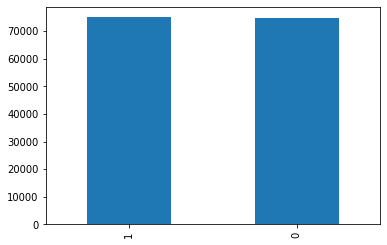

In [13]:
# 위의 결과를 보면 훈련용 리뷰의 경우 14만여 개, 테스트용 리뷰의 경우 5만여 개가 존재한다.

# 훈련 데이터의 레이블의 분포(긍정 versus 부정 감정)를 확인해보자. 고르게 분포한다.
train_data['label'].value_counts().plot(kind = 'bar')

In [14]:
# 정확한 수치로는...
print(train_data.groupby('label').size().reset_index(name='count'))

   label  count
0      0  74918
1      1  75013


## 데이터 정제하기
* 정규 표현식을 사용하여 한글을 제외하고 모두 제거해준다. 이 과정에서 빈 샘플이 생겼다면 그 행을 제거해주는 것까지 마무리.

In [15]:
# 한글과 공백을 제외하고 모두 제거
train_data['reviews'] = train_data['reviews'].str.replace('[^ㄱ-ㅎㅏ-ㅣ가-힣 ]', '')
#train_data['reviews'].replace('', np.nan, inplace=True) 이거 안해도 되는데 왜 나오는지 모르겠다.
print(train_data.isnull().sum())

ratings    0
reviews    0
label      0
dtype: int64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [16]:
# 테스트 데이터에 대해서도 같은 과정 수행.
test_data.drop_duplicates(subset=['reviews'], inplace=True) # 중복 제거
test_data['reviews'] = test_data['reviews'].str.replace('[^ㄱ-ㅎㅏ-ㅣ가-힣 ]', '') # 정규포현식 수행; 한글과 공백 아닌 모든 문자열 공백으로 전환.
test_data['reviews'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경. 마찬가지로 이걸 굳이 왜 하는지 모르겠다.
test_data = test_data.dropna(how='any') # Null 값 제거.
print('전처리 후 테스트용 샘플의 개수 :', len(test_data))

전처리 후 테스트용 샘플의 개수 : 49977


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:4582: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#r

## 토큰화

In [17]:
# Okt가 아닌 Mecab을 사용하여 토큰화 작업을 수행하자. 다음은 임의의 문장에 대해서 테스트한 토큰화 예시
mecab = Mecab()
print(mecab.morphs('와 이런 것도 상품이라고 차라리 내가 만드는 게 나을 뻔'))

['와', '이런', '것', '도', '상품', '이', '라고', '차라리', '내', '가', '만드', '는', '게', '나을', '뻔']


In [18]:
# 불용어를 지정하여 필요없는 토큰들은 제거하도록 한다.
stopwords = ['도', '는', '다', '의', '가', '이', '은', '한', '에', '하', '고', '을', '를', '인', '듯', '과', '와', '네', '들', '듯', '지', '임', '게']

In [19]:
# 훈련 데이터와 테스트 데이터 모두에 대해 동일한 과정을 거친다.
train_data['tokenized'] = train_data['reviews'].apply(mecab.morphs)
train_data['tokenized'] = train_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])

test_data['tokenized'] = test_data['reviews'].apply(mecab.morphs)
test_data['tokenized'] = test_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


## 단어와 길이 분포 확인하기

In [20]:
# 긍정 리뷰, 부정 리뷰 각각 어떤 단어들이 많이 등장하고, 부정 리뷰에는 주로 어떤 단어들이 등장하는지 두 가지 경우에 대해서 각 단어의 빈도수를 계산해보자.
# 이를 위해 각 레이블에 따라서 별도로 단어들의 리스트를 저장해두어야 한다.
negative_words = np.hstack(train_data[train_data.label == 0]['tokenized'].values)
positive_words = np.hstack(train_data[train_data.label == 1]['tokenized'].values)

In [21]:
# Counter()를 사용하여 각 단어에 대한 빈도수를 카운트한다. 가장 많은 빈도수 20위까지를 보자.
negative_word_count = Counter(negative_words)
print(negative_word_count.most_common(20))

[('네요', 31799), ('는데', 20295), ('안', 19718), ('어요', 14849), ('있', 13200), ('너무', 13058), ('했', 11783), ('좋', 9812), ('배송', 9677), ('같', 8997), ('구매', 8876), ('어', 8869), ('거', 8854), ('없', 8670), ('아요', 8642), ('습니다', 8436), ('그냥', 8355), ('되', 8345), ('잘', 8029), ('않', 7984)]


In [22]:
# '네요', '는데', '안', '않', '너무', '없' 과 같은 단어들이 부정 리뷰에서 주로 등장함을 볼 수 있다. 긍정 리뷰에 대해서도 동일하게 출력해보자.
positive_word_count = Counter(positive_words)
print(positive_word_count.most_common(20))

[('좋', 39488), ('아요', 21184), ('네요', 19895), ('어요', 18686), ('잘', 18602), ('구매', 16171), ('습니다', 13320), ('있', 12391), ('배송', 12275), ('는데', 11670), ('했', 9818), ('합니다', 9801), ('먹', 9635), ('재', 9273), ('너무', 8397), ('같', 7868), ('만족', 7261), ('거', 6482), ('어', 6294), ('쓰', 6292)]


긍정 리뷰의 평균 길이 : 13.5877381253916
부정 리뷰의 평균 길이 : 17.02948557089084


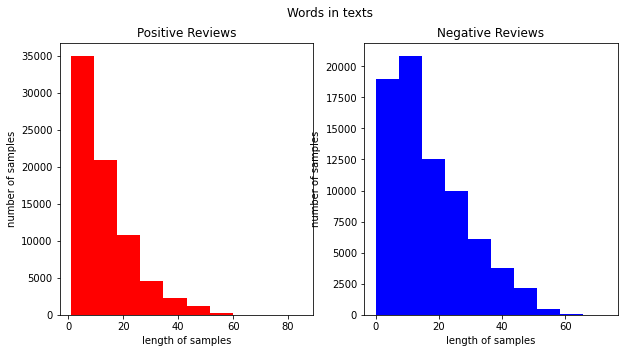

In [23]:
# 긍정 리뷰에는 '좋', '아요', '네요', '잘', '너무', '만족' 등과 같은 단어들이 주로 많이 등장한다.

# 이제는 도수분포표 그래프를 통해 각각의 길이 분포를 확인해보자.
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
text_len = train_data[train_data['label']==1]['tokenized'].map(lambda x: len(x))
ax1.hist(text_len, color='red')
ax1.set_title('Positive Reviews')
ax1.set_xlabel('length of samples')
ax1.set_ylabel('number of samples')
print('긍정 리뷰의 평균 길이 :', np.mean(text_len))

text_len = train_data[train_data['label']==0]['tokenized'].map(lambda x: len(x))
ax2.hist(text_len, color='blue')
ax2.set_title('Negative Reviews')
fig.suptitle('Words in texts')
ax2.set_xlabel('length of samples')
ax2.set_ylabel('number of samples')
print('부정 리뷰의 평균 길이 :', np.mean(text_len))
plt.show()

In [24]:
# 긍정 리뷰보다 부정 리뷰가 좀 더 길게 작성된 경향이 있다.
X_train = train_data['tokenized'].values
y_train = train_data['label'].values
X_test = test_data['tokenized'].values
y_test = test_data['label'].values

## 정수 인코딩

In [25]:
# 기계가 텍스트를 숫자로 처리할 수 있도록 훈련 데이터와 테스트 데이터에 정수 인코딩을 하자.

# 우선, 훈련 데이터에 대해서 단어 집합(vocaburary)을 만들어보자.
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [26]:
# 단어 집합이 생성됨과 동시에 각 단어에 고유한 정수가 부여됐다.
# 이는 tokeniser.word_index를 출력하여 확인 가능하다.
# 낮은 빈도수, 등장 횟수가 1회인 단어들은 자연어 처리에서 배제하고자 한다. 우선 이 단어들이 데이터셋에서 얼마나 비중을 차지하는지 확인해보자.
threshold = 2
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 아래 반복문을 통해 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for keys, value in tokenizer.word_counts.items():
  total_freq += value

  # 단어의 등장 빈도수가 threshold보다 작으면
  if (value < threshold):
    rare_cnt += 1
    rare_freq += value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s' %(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어의 비율 :', (rare_cnt / total_cnt)*100)
print('전체 등장 빈도에서 희귀 단어 등장 빈도 비율 :', (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 39998
등장 빈도가 1번 이하인 희귀 단어의 수: 18213
단어 집합에서 희귀 단어의 비율 : 45.53477673883694
전체 등장 빈도에서 희귀 단어 등장 빈도 비율 : 0.7935698749320282


In [27]:
# 약 4만 개의 토큰화 된 단어 중,
# 등장 빈도가 threshold인 2회 미만, 즉 1회인 단어들은 단어 집합에서 약 45%를 차지한다.
# 하지만, 전체 등장 빈도에서 차지하는 비중은 매우 적은 수치인 0/8% 밖에 되지 않는다.
# 등장 빈도가 1회인 단어들은 이러한 이유로 중요도가 낮다고 판단, 정수 인코딩에서 배제.

# 등장 빈도수가 1인 단어들의 수를 제외한 단어의 개수를 단어 집합의 최대 크기로 제한한다.
# 2를 빼는 이유 = 0번 패딩 토큰과 1번 OOV 토큰을 고려해서.
vocab_size = total_cnt - rare_cnt + 2
print('단어 집합의 크기 :', vocab_size)

단어 집합의 크기 : 21787


In [28]:
# 21,787개의 단어를 토크나이저 인자로 넘겨주면 토크나이저는 텍스트 시퀀스를 숫자 시퀀스로 변환.
# 정수 인코딩 과정에서 이보다 큰 숫자가 부여된 단어들은 OOV(out-of-vocaburary로 변환한다.
tokenizer = Tokenizer(vocab_size, oov_token = 'OOV')
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)
# OOV 토큰은 왜 발생하는걸까?

In [29]:
# 정수 인코딩이 어떻게 되었는지 상위 3개 샘플씩 확인해보자.
print(X_train[:3])
print(X_test[:3])

[[67, 2060, 299, 14259, 263, 73, 6, 236, 168, 137, 805, 2951, 625, 2, 77, 62, 207, 40, 1343, 155, 3, 6], [482, 409, 52, 8530, 2561, 2517, 339, 2918, 250, 2357, 38, 473, 2], [46, 24, 825, 105, 35, 2372, 160, 7, 10, 8061, 4, 1319, 29, 140, 322, 41, 59, 160, 140, 7, 1916, 2, 113, 162, 1379, 323, 119, 136]]
[[14, 704, 767, 116, 186, 252, 12], [339, 3904, 62, 3816, 1651], [11, 69, 2, 49, 164, 3, 27, 15, 6, 513, 289, 17, 92, 110, 564, 59, 7, 2]]


## 패딩(Padding)

리뷰의 최대 길이 : 85
리뷰의 평균 길이 : 15.307521459871541


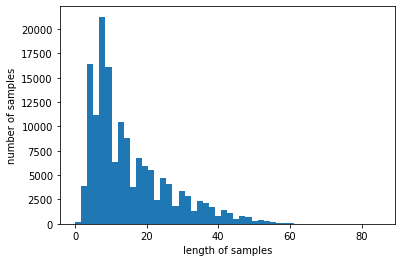

In [30]:
# 서로 다른 길이 샘플들을 같은 길이로 맞춰주는 작업.
# 전체 데이터의 샘플들의 길이 분포를 알아보자.

print('리뷰의 최대 길이 :', max(len(l) for l in X_train))
print('리뷰의 평균 길이 :', sum(map(len, X_train))/len(X_train))
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [31]:
# 최대 길이가 85이다. 만약 80으로 패딩할 경우 얼마나 샘플들을 보전할 수 있는지 보자.
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if (len(s) <= max_len):
      cnt += 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율 : %s'%(max_len, (cnt/len(nested_list)*100)))

max_len = 80
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 80 이하인 샘플의 비율 : 99.99933302652553


In [32]:
# 99.999%가 80 이하의 길이를 가진다. training 리뷰의 길이를 80으로 패딩하자.
X_train = pad_sequences(X_train, maxlen= max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

# GRU로 네이버 쇼핑 리뷰 감성 분류하기

In [33]:
from tensorflow.keras.layers import Embedding, Dense, GRU
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [34]:
model = Sequential()
model.add(Embedding(vocab_size, 100))
model.add(GRU(128))
model.add(Dense(1, activation='sigmoid'))

In [35]:
es = EarlyStopping(monitor='val_loss', mode = 'min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [36]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs = 15, callbacks=[es, mc], batch_size=60, validation_split=0.2)


Epoch 1/15
2000/2000 [==============================] - 52s 22ms/step - loss: 0.2729 - acc: 0.8971 - val_loss: 0.2259 - val_acc: 0.9182

Epoch 00001: val_acc improved from -inf to 0.91816, saving model to best_model.h5
Epoch 2/15
2000/2000 [==============================] - 44s 22ms/step - loss: 0.2150 - acc: 0.9218 - val_loss: 0.2075 - val_acc: 0.9265

Epoch 00002: val_acc improved from 0.91816 to 0.92653, saving model to best_model.h5
Epoch 3/15
2000/2000 [==============================] - 43s 21ms/step - loss: 0.1981 - acc: 0.9289 - val_loss: 0.2345 - val_acc: 0.9137

Epoch 00003: val_acc did not improve from 0.92653
Epoch 4/15
2000/2000 [==============================] - 44s 22ms/step - loss: 0.1873 - acc: 0.9336 - val_loss: 0.2072 - val_acc: 0.9251

Epoch 00004: val_acc did not improve from 0.92653
Epoch 5/15
2000/2000 [==============================] - 43s 21ms/step - loss: 0.1776 - acc: 0.9374 - val_loss: 0.2052 - val_acc: 0.9264

Epoch 00005: val_acc did not improve from 0.9265

In [37]:
loaded_model = load_model('best_model.h5')
print('\n 테스트 정확도 : %.4f' %(loaded_model.evaluate(X_test, y_test)[1]))

1562/1562 [==============================] - 13s 8ms/step - loss: 0.2156 - acc: 0.9235

 테스트 정확도 : 0.9235


# 리뷰 예측

In [43]:
def sentiment_predict(new_sentence):
  new_sentence = mecab.morphs(new_sentence) # 토큰화
  new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
  encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
  pad_new = pad_sequences(encoded, max_len) # 패딩
  score = float(loaded_model.predict(pad_new)) # 예측
  if score > 0.5:
    print('{:.2f}% 확률로 긍정 리뷰입니다.'.format(score*100))
  else:
    print('{:.2f}% 확률로 부정 리뷰입니다.'.format((1-score)*100))

In [41]:
sentiment_predict('이 상품 진짜 좋아요... 저는 강추합니다. 대박')

98.44% 확률로 긍정 리뷰입니다.


In [44]:
sentiment_predict('진짜 배송도 늦고 개짜증나네요. 뭐 이런 걸 상품이라고 만듬?')

99.06% 확률로 부정 리뷰입니다.


In [45]:
sentiment_predict('판매자님... 너무 짱이에요.. 대박나삼')

98.32% 확률로 긍정 리뷰입니다.


In [46]:
sentiment_predict('ㅁㄴㅇㄻㄴㅇㄻㄴㅇ리뷰쓰기도 귀찮아')

73.86% 확률로 부정 리뷰입니다.
